In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pymc_bart as pmb
import statsmodels.api as sm

In [3]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
import os
base_dir = './data'
save_dir = './data/bart_plots'

df_dict = {}

for filename in os.listdir(base_dir):
    if filename.endswith('.csv'):
        key = filename.split('.')[0]
        dataframe = pd.read_csv(os.path.join(base_dir, filename))
        df_dict[key] = dataframe

In [68]:
# print("mean of outcomes by treatment")
# data_df.groupby("A")[["Y"]].mean()

In [112]:
# data_df["Y"].std()

In [7]:
# Add propensity scores to data df

from sklearn.linear_model import LogisticRegression

for keyv in df_dict.keys():

    data_df = df_dict[keyv]
    input_df = data_df.drop(["A","Y"],axis=1)

    # drop string type covariates instead of encoding them for now
    str_type_cols = input_df.select_dtypes('object').columns
    input_df = input_df.drop(str_type_cols,axis=1)

    lr = LogisticRegression(max_iter=5000)
    lr.fit(input_df, data_df["A"])
    pred_prob = lr.predict_proba(input_df)  # probabilities for classes
#     print(pred_prob[:,1])

    # the propensity score (ps) is the probability of being in the treatment group
    df_dict[keyv]['ps'] = pred_prob[:, 1]
    
# #     reorder columns
#     columns = df_dict[keyv].columns.tolist()
#     columns = [columns[-2]] + [columns[-1]] + columns[:-2]
#     df_dict[keyv] = df_dict[keyv][columns]

In [119]:
# df_dict["dataA"]

### straightforward implementation of BART

In [8]:
def bart_model_fn(input_df,Y,num_trees,var_prior=1,mcmc_draw=1500,mcmc_chain=4):

    with pm.Model() as bart_1:

        X = pm.MutableData("X", input_df)

        var = pm.HalfNormal('var', var_prior)
        mu = pmb.BART('mu', X, Y, m=num_trees)
        y = pm.Normal('y', mu, var, observed=Y)

        idata_bart_g1 = pm.sample(mcmc_draw, chains=mcmc_chain,random_seed=RANDOM_SEED,idata_kwargs={"log_likelihood": True})

    print("idata done")
    
#     leave_one_out_cv = az.loo(idata_bart_g1)

    with bart_1:
        X_1 = input_df.copy()
        X_1["A"] = 1
        X.set_value(X_1)

        posterior_predictive_bart_1 = pm.sample_posterior_predictive(
            trace=idata_bart_g1, random_seed=RANDOM_SEED)

    print("1 done")

    with bart_1:
        X_0 = input_df.copy()
        X_0["A"] = 0
        X.set_value(X_0)

        posterior_predictive_bart_0 = pm.sample_posterior_predictive(
            trace=idata_bart_g1, random_seed=RANDOM_SEED)

    print("0 done")
    
    return {'model':bart_1,'trace':idata_bart_g1,'y0':posterior_predictive_bart_0,'y1':posterior_predictive_bart_1}

In [ ]:
ate_posterior_dict = {}
all_posterior_dict = {}

vp = 1
mcmcd = 2000
mcmcc = 4

for keyv in df_dict.keys():

    print(keyv)

    data_df = df_dict[keyv]
    input_df = data_df.drop(["Y","ps"],axis=1)
    # drop string type covariates instead of encoding them for now
    str_type_cols = input_df.select_dtypes('object').columns
    input_df = input_df.drop(str_type_cols,axis=1)
    # REORDER columns
    columns = input_df.columns.tolist()
    columns = [columns[-1]] + columns[:-1]
    input_df = input_df[columns]

    Y = data_df["Y"]
       
    out_models = {}
    out_models_trace = {}

    for num_trees in [50,75,100]:
        vp_val = vp
        if(vp=='std'):
            vp_val = Y.std()

        out_dict = bart_model_fn(input_df,Y,num_trees,var_prior=vp_val,mcmc_draw=mcmcd,mcmc_chain=mcmcc)
        out_models_trace[num_trees] = out_dict['trace']
        out_models[num_trees] = out_dict

    df_comp_loo = az.compare(out_models_trace)

    best_key = int(df_comp_loo.iloc[0].name)
    del(out_models_trace)
    
    best_model = out_models[best_key]
    del(out_models)
    
    posterior_predictive_bart_1 = best_model['y1']
    posterior_predictive_bart_0 = best_model['y0']

    all_posterior_dict[keyv] = [posterior_predictive_bart_1,posterior_predictive_bart_0]

    # Extract posterior predictive samples for treatment and control
    posterior_treatment = posterior_predictive_bart_1.posterior_predictive["y"].values.squeeze()
    posterior_control = posterior_predictive_bart_0.posterior_predictive["y"].values.squeeze()

    # Compute the posterior distribution of the ATE
    posterior_ATE = posterior_treatment - posterior_control

    mean_ATE = np.mean(posterior_ATE,axis=2)
    keyv_new = f"{keyv}_{best_key} trees"
    ate_posterior_dict[keyv] = mean_ATE

posterior_data = az.from_dict(posterior=ate_posterior_dict)
az.plot_posterior(posterior_data, hdi_prob=0.95)
plt.savefig(save_dir+f"/alldata_posterior_var{vp}_mcmc{mcmcd}_{mcmcc}.png")

In [64]:
# az.plot_trace(best_model['trace'])

In [51]:
sorted_keys = sorted(ate_posterior_dict.keys())
sorted_ate_posteriors = {key: ate_posterior_dict[key] for key in sorted_keys}

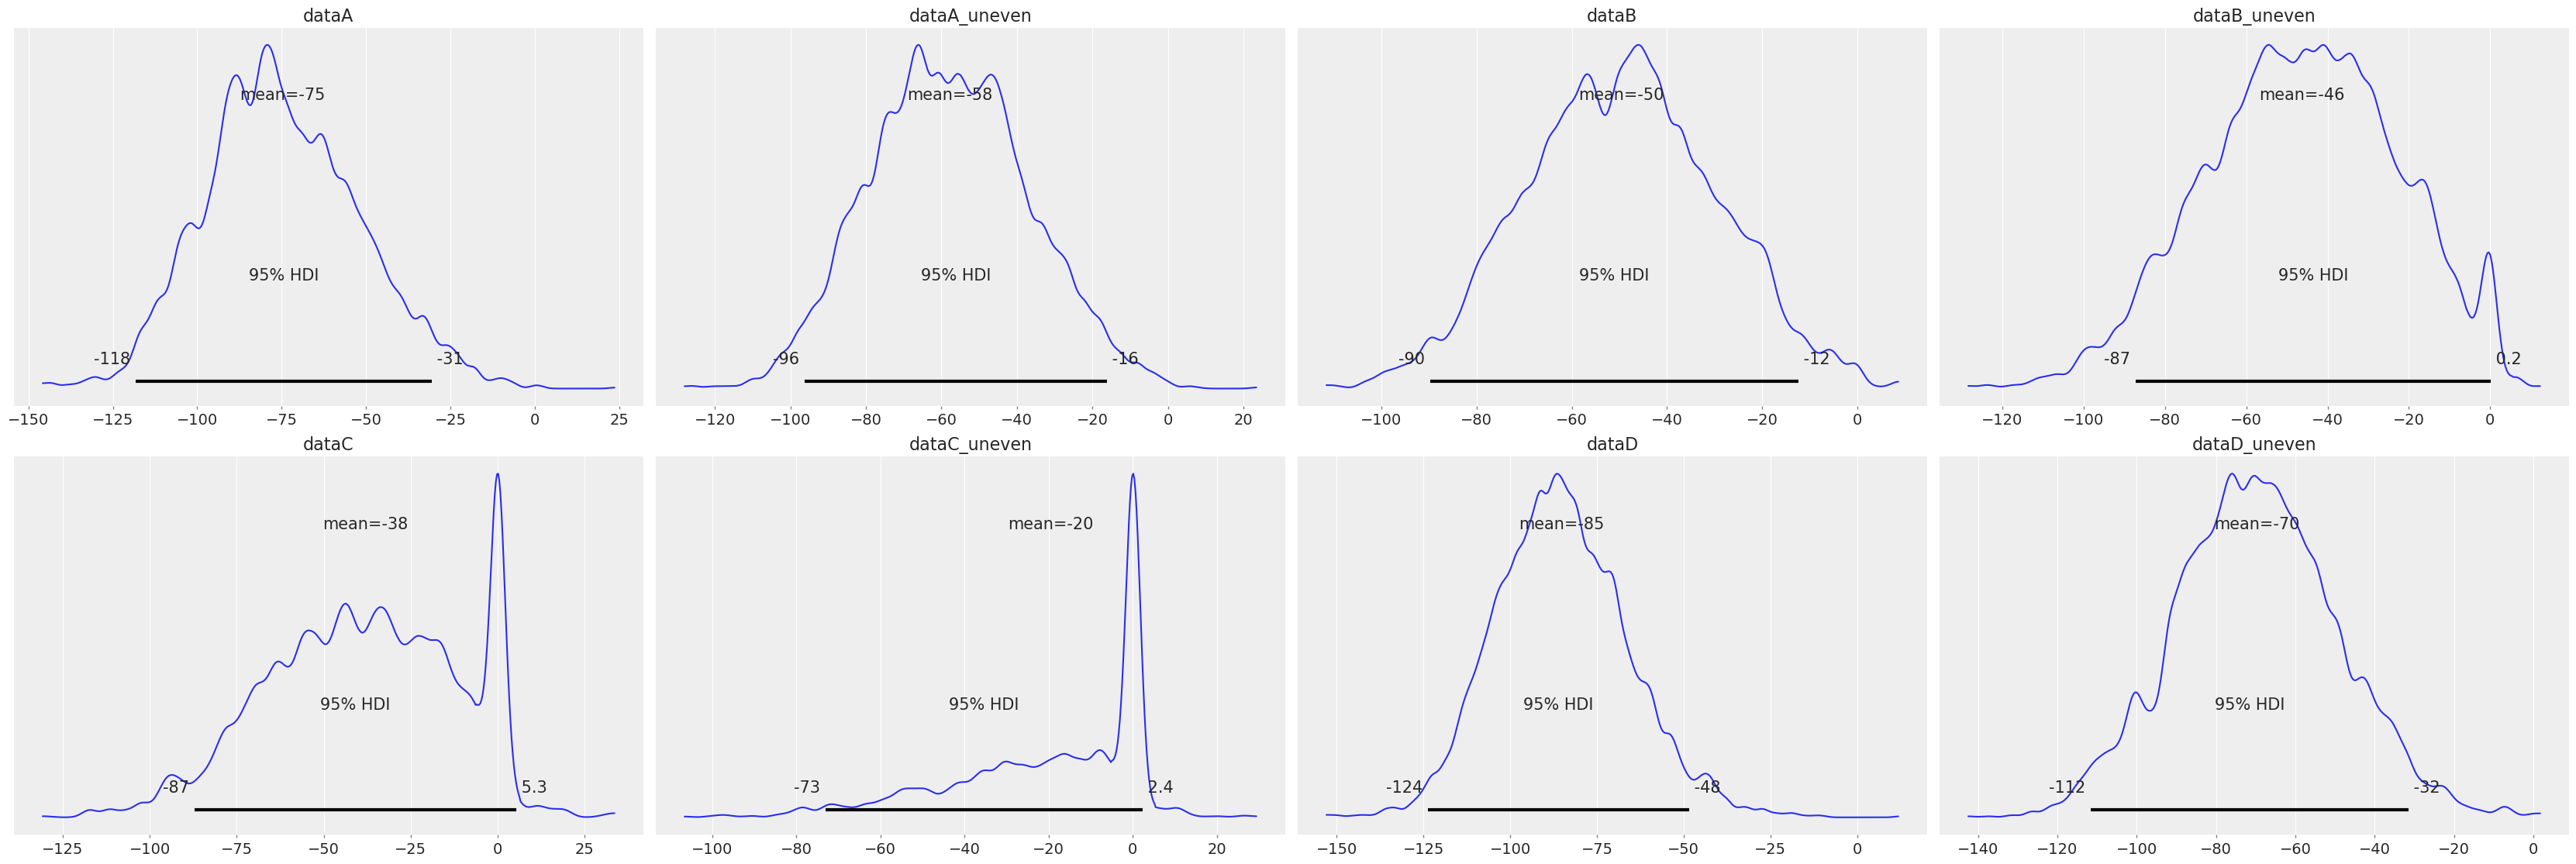

In [53]:
posterior_data = az.from_dict(posterior=sorted_ate_posteriors)
posterior_data.to_netcdf(save_dir + f"/jup_simplebart_all_var{vp}_mcmc{mcmcd}_{mcmcc}.nc")
az.plot_posterior(posterior_data, hdi_prob=0.95)
plt.savefig(save_dir+f"/alldata_posterior_var{vp}_mcmc{mcmcd}_{mcmcc}.png")

In [55]:
# posterior_data = az.from_dict(posterior=ate_posterior_dict)
# az.plot_posterior(posterior_data, hdi_prob=0.95)
# plt.savefig(save_dir+"/posterior_bart_simple.png")
# # az.plot_violin(posterior_data, hdi_prob=0.95)

In [54]:
# az.plot_posterior(posterior_data, hdi_prob=0.95)
# plt.savefig(save_dir+"/posterior_bart_simple.png")

### including propensity scores as a covariate in BART

In [ ]:
ate_posterior_dict_ps = {}
all_posterior_dict_ps = {}

vp = 1
mcmcd = 2000
mcmcc = 4

for keyv in df_dict.keys():

    print(keyv)

    data_df = df_dict[keyv]
    input_df = data_df.drop(["Y"],axis=1)

    # drop string type covariates instead of encoding them for now
    str_type_cols = input_df.select_dtypes('object').columns
    input_df = input_df.drop(str_type_cols,axis=1)
    # REORDER columns
    columns = input_df.columns.tolist()
    columns = [columns[-2]] + [columns[-1]] + columns[:-2]
    input_df = input_df[columns]

    Y = data_df["Y"]
       
    out_models = {}
    out_models_trace = {}

    for num_trees in [50,75,100]:
        out_dict = bart_model_fn(input_df,Y,num_trees,var_prior=vp,mcmc_draw=mcmcd,mcmc_chain=mcmcc)
        out_models_trace[num_trees] = out_dict['trace']
        out_models[num_trees] = out_dict

    df_comp_loo = az.compare(out_models_trace)

    best_key = int(df_comp_loo.iloc[0].name)
    del(out_models_trace)
    
    best_model = out_models[best_key]
    del(out_models)
    
    posterior_predictive_bart_1 = best_model['y1']
    posterior_predictive_bart_0 = best_model['y0']

    all_posterior_dict_ps[keyv] = [posterior_predictive_bart_1,posterior_predictive_bart_0]

    # Extract posterior predictive samples for treatment and control
    posterior_treatment = posterior_predictive_bart_1.posterior_predictive["y"].values.squeeze()
    posterior_control = posterior_predictive_bart_0.posterior_predictive["y"].values.squeeze()

    # Compute the posterior distribution of the ATE
    posterior_ATE = posterior_treatment - posterior_control

    mean_ATE = np.mean(posterior_ATE,axis=2)
    keyv_new = f"{keyv}_{best_key} trees"
    ate_posterior_dict_ps[keyv_new] = mean_ATE

In [65]:
# ate_posterior_dict_ps
sorted_keys = sorted(ate_posterior_dict_ps.keys())
sorted_ate_posteriors_ps = {key: ate_posterior_dict_ps[key] for key in sorted_keys}

posterior_data_ps = az.from_dict(posterior=sorted_ate_posteriors_ps)
posterior_data_ps.to_netcdf(save_dir + f"/jup_ps_bart_all_var{vp}_mcmc{mcmcd}_{mcmcc}.nc")
az.plot_posterior(posterior_data_ps, hdi_prob=0.95)
plt.savefig(save_dir+f"/alldata_posterior_ps_var{vp}_mcmc{mcmcd}_{mcmcc}.png")

## plotting the posteriors together

In [ ]:
loaded_data = az.from_netcdf(save_dir + f"/jup_ps_bart_all_var{vp}_mcmc{mcmcd}_{mcmcc}.nc")
loaded_data_simple = az.from_netcdf(save_dir + f"/jup_simplebart_all_var{vp}_mcmc{mcmcd}_{mcmcc}.nc")

In [ ]:
# az.plot_posterior(loaded_data, hdi_prob=0.95,ref_val=-100, point_estimate='mode')
import seaborn as sns
colors = sns.color_palette("tab10")
# print(colors)

In [ ]:
var_names = loaded_data.posterior.data_vars.keys()

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
labeller = az.labels.MapLabeller({key: "" for key in var_names})

var_names1 = loaded_data_simple.posterior.data_vars.keys()
labeller1 = az.labels.MapLabeller({key: key[4:] for key in var_names1})

fig, axes = plt.subplots(2, 4, figsize=(4*6, 4*2))

# Plot density plots for each pair of variables
for i, var_name in enumerate(var_names):
    col = i // 2
    row = i%2
    ax1 = axes[row,col]
#     ax2 = axes[row,col]
    vns_tmp = var_name.split('_')
#     print()
    lbl_tmp = vns_tmp[0]
    if(len(vns_tmp)>2):
        lbl_tmp+='_'+vns_tmp[1]

        
    col1 = colors[i%2]
    col2 = colors[(i+1)%2]
    az.plot_posterior(loaded_data, var_names=[var_name], ax=ax1, show=False, label='include_propensity', color=col1,point_estimate=None,hdi_prob='hide',labeller=labeller)
    az.plot_posterior(loaded_data_simple, var_names=[lbl_tmp], ax=ax1, show=False, label='only_cov_and_treat', color=col2,point_estimate=None,hdi_prob='hide',labeller=labeller1)

    ax1.axvline(-100, linestyle='dotted', color='black')
    ax1.set_xlim(-150, 25)
    ax2.axvline(-100, linestyle='dotted', color='black')
    ax2.set_xlim(-150, 25)

# plt.xlabel("ATE")
fig.supxlabel('Average Treatment Effect')
fig.supylabel('Density')
plt.savefig(save_dir + f"/ps_ATEs_.png")
plt.show()

In [23]:
# m_ps_logit, idata_logit = make_propensity_model(cov_df, treat_df, bart=False, samples=1000)

### implementation of Han et al's propensity score model : BROKEN / leads to ERRORS

In [ ]:
data_df = df_dict["dataA"]
input_df = data_df.drop(["Y","A"],axis=1)
str_type_cols = input_df.select_dtypes('object').columns
input_df = input_df.drop(str_type_cols,axis=1)

no_ps_input = input_df.drop(["ps"],axis=1)
treat_df = data_df["A"]
Y = data_df["Y"]

with pm.Model() as bm:
    
    X = pm.MutableData("X", treat_df)

    var = pm.HalfNormal('var', 1)

    mu_ = pmb.BART('mu_', input_df, Y, m=50)

    tau_ = pmb.BART('tau_', no_ps_input, Y, m=50)

    y = pm.Normal('y',  mu = mu_ + tau_*Y, sigma=var, observed=Y)

    idata_bart_g1 = pm.sample(1500, chains=2,random_seed=42,idata_kwargs={"log_likelihood": True}, init='advi+adapt_diag')